In [1]:
import matplotlib.patches as patches
from matplotlib.path import Path
import re
from icecream import ic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_theme(palette="colorblind")
sns.set_style("white", {'axes.grid': False})
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def make_parallel_plot(df, lower_is_better=False) -> matplotlib.figure.Figure:
    ynames = df.columns
    ys = df[ynames].values
    target = df[ynames[-1]].to_numpy()  # Target values

    ymaxs = ys.max(axis=0)
    ymins = ys.min(axis=0)
    # ymins = np.zeros_like(ymaxs)
    ymins[: -1] = np.zeros_like(ymaxs)[: -1]

    dys = ymaxs - ymins
    ymins -= dys * 0.05  # add 5% padding below and above
    ymaxs += dys * 0.05

    # reverse axis 1 to have less crossings
    # ymaxs[1], ymins[1] = ymins[1], ymaxs[1]

    # Reverse loss axes to highlight that lower is better
    # ymaxs[-1], ymins[-1] = ymins[-1], ymaxs[-1]
    # ymaxs[-2], ymins[-2] = ymins[-2], ymaxs[-2]
    if lower_is_better:
        ymaxs[-1], ymins[-1] = ymins[-1], ymaxs[-1]

    dys = ymaxs - ymins

    # transform all data to be compatible with the main axis
    zs = np.zeros_like(ys)
    zs[:, 0] = ys[:, 0]
    zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

    fig, host = plt.subplots(figsize=(20, 8))

    axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
    for i, ax in enumerate(axes):
        ax.set_ylim(ymins[i], ymaxs[i])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if ax != host:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('right')
            ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

    host.set_xlim(0, ys.shape[1] - 1)
    host.set_xticks(range(ys.shape[1]))
    host.set_xticklabels(ynames, fontsize=14)
    host.tick_params(axis='x', which='major', pad=7)
    host.spines['right'].set_visible(False)
    host.xaxis.tick_top()

    if lower_is_better:
        cmap = sns.color_palette("plasma_r", as_cmap=True)
        norm = plt.Normalize(vmin=ymaxs[-1], vmax=ymins[-1])
    else:
        cmap = sns.color_palette("plasma", as_cmap=True)
        norm = plt.Normalize(vmin=ymins[-1], vmax=ymaxs[-1])

    legend_handles = [None for _ in np.unique(target)]
    for j in range(ys.shape[0]):
        # create bezier curves
        verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                         np.repeat(zs[j, :], 3)[1:-1]))
        codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
        path = Path(verts, codes)
        patch = patches.PathPatch(
            path,
            facecolor='none',
            lw=1,
            alpha=0.7,
            edgecolor=cmap(norm(target[j])),
        )
        # legend_handles[target[j]] = patch
        host.add_patch(patch)

    # Uncomment the following lines if you want to add a legend
    # host.legend(legend_handles, np.unique(target),
    #             loc='lower center', bbox_to_anchor=(0.5, -0.18),
    #             ncol=len(np.unique(target)), fancybox=True, shadow=True)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax, pad=-0)
    # cbar.set_ticks([])
    # cbar.set_ticklabels([])
    # cbar.outline.set_visible(False)
    if lower_is_better:
        cbar.ax.invert_yaxis()

    ax.set_yticks([])
    ax.set_yticklabels([])

    plt.tight_layout()
    plt.show()

    return fig

In [3]:
import wandb

# Initialize API
api = wandb.Api()

# Define the project and entity (replace with your values)
entity = "tsturm-university-kassel"  # e.g., "my-team"
project = "rl"

# Fetch runs from the project with the specific group
runs = api.runs(f"{entity}/{project}", filters={"group": "gauss_charging_centered_AV"})

data = []
for run in runs:
    row = {
        # "run_id": run.id,
        "Name": run.name,
        "run_name": run.name,
    } | {
        k: v for k, v in run.summary.items()
    } | {
        k: v for k, v in run.config.items()
    }
    data.append(row)

# Convert to DataFrame
df = pd.DataFrame(data).drop(columns="run_name")
df = df.set_index("Name")
df = df.sort_values(by="eval/return")
df.head()

,_runtime,_step,_timestamp,_wandb,charts/SPS,charts/episodic_length,charts/episodic_return,charts/learning_rate,eval/SoC >= 90%,eval/grid usage,...,train/median SoC,train/unused PV,lr_rl,gamma_rl,vf_coef_rl,ent_coef_rl,clip_coef_rl,gae_lambda_rl,max_grad_norm_rl,num_steps / batch_size
Name,,,,,,,,,,,,,,,,,,,,,
RL__6c24ded8-568b-4800-b8e9-2dcfb22287d4,23854.796624,11190,1.750388e+09,{'runtime': 23854},30,132,203.375427,4.765315e-08,0.619718,0.436582,...,0.991783,0.218737,0.000067,0.962528,0.769274,0.000681,0.918582,0.494212,0.314842,512
RL__82b4fab2-9489-4132-a06d-d97260e41ee9,15399.455370,10127,1.750380e+09,{'runtime': 15399},46,139,221.846771,7.490749e-07,0.697183,0.450080,...,0.997852,0.193345,0.000261,0.943764,0.288537,0.000138,0.347299,0.424070,0.679473,2048
RL__cb3d69ad-b821-4217-a866-6572c4fed1ad,48956.514555,12588,1.750413e+09,{'runtime': 48956},14,132,199.724808,8.589750e-07,0.598592,0.452166,...,0.997424,0.233642,0.002402,0.916987,0.261449,0.000006,0.788545,0.006536,0.603911,256
RL__755aab38-4c9b-4754-9a93-0649e03ca5ac,20991.805739,10491,1.750385e+09,{'runtime': 20991},34,132,198.431107,5.330223e-07,0.676056,0.457000,...,0.999680,0.242426,0.000373,0.969389,0.236546,0.000026,0.102425,0.269306,0.374217,1024
RL__572f2448-4110-4f11-95e2-b37fc8073812,14334.420571,10127,1.750379e+09,{'runtime': 14334},49,139,219.458359,1.800526e-07,0.718310,0.453670,...,0.997852,0.206628,0.000063,0.926344,0.626180,0.000003,0.288427,0.040481,0.320064,2048


In [4]:
# df = pd.read_csv("beta_charging_centered_AV.csv", index_col=0)\
#     .fillna(0)\
#     # .rename(columns=lambda x: re.sub('imitation/', '', x))
# df.head()

In [5]:
df_hyperparameters = df[["lr_rl", "ent_coef_rl", "gamma_rl", "gae_lambda_rl", "max_grad_norm_rl", "vf_coef_rl", "clip_coef_rl","num_steps / batch_size", "eval/return"]]
df_hyperparameters= df_hyperparameters.rename(columns=lambda x: re.sub('eval/', '', x))
df_hyperparameters= df_hyperparameters.rename(columns=lambda x: re.sub('num_steps /', '', x))
df_hyperparameters= df_hyperparameters.rename(columns=lambda x: re.sub('_rl', '', x))
df_hyperparameters.head()

,lr,ent_coef,gamma,gae_lambda,max_grad_norm,vf_coef,clip_coef,batch_size,return
Name,,,,,,,,,
RL__6c24ded8-568b-4800-b8e9-2dcfb22287d4,0.000067,0.000681,0.962528,0.494212,0.314842,0.769274,0.918582,512,52.335379
RL__82b4fab2-9489-4132-a06d-d97260e41ee9,0.000261,0.000138,0.943764,0.424070,0.679473,0.288537,0.347299,2048,52.457973
RL__cb3d69ad-b821-4217-a866-6572c4fed1ad,0.002402,0.000006,0.916987,0.006536,0.603911,0.261449,0.788545,256,52.473783
RL__755aab38-4c9b-4754-9a93-0649e03ca5ac,0.000373,0.000026,0.969389,0.269306,0.374217,0.236546,0.102425,1024,52.599988
RL__572f2448-4110-4f11-95e2-b37fc8073812,0.000063,0.000003,0.926344,0.040481,0.320064,0.626180,0.288427,2048,53.002822


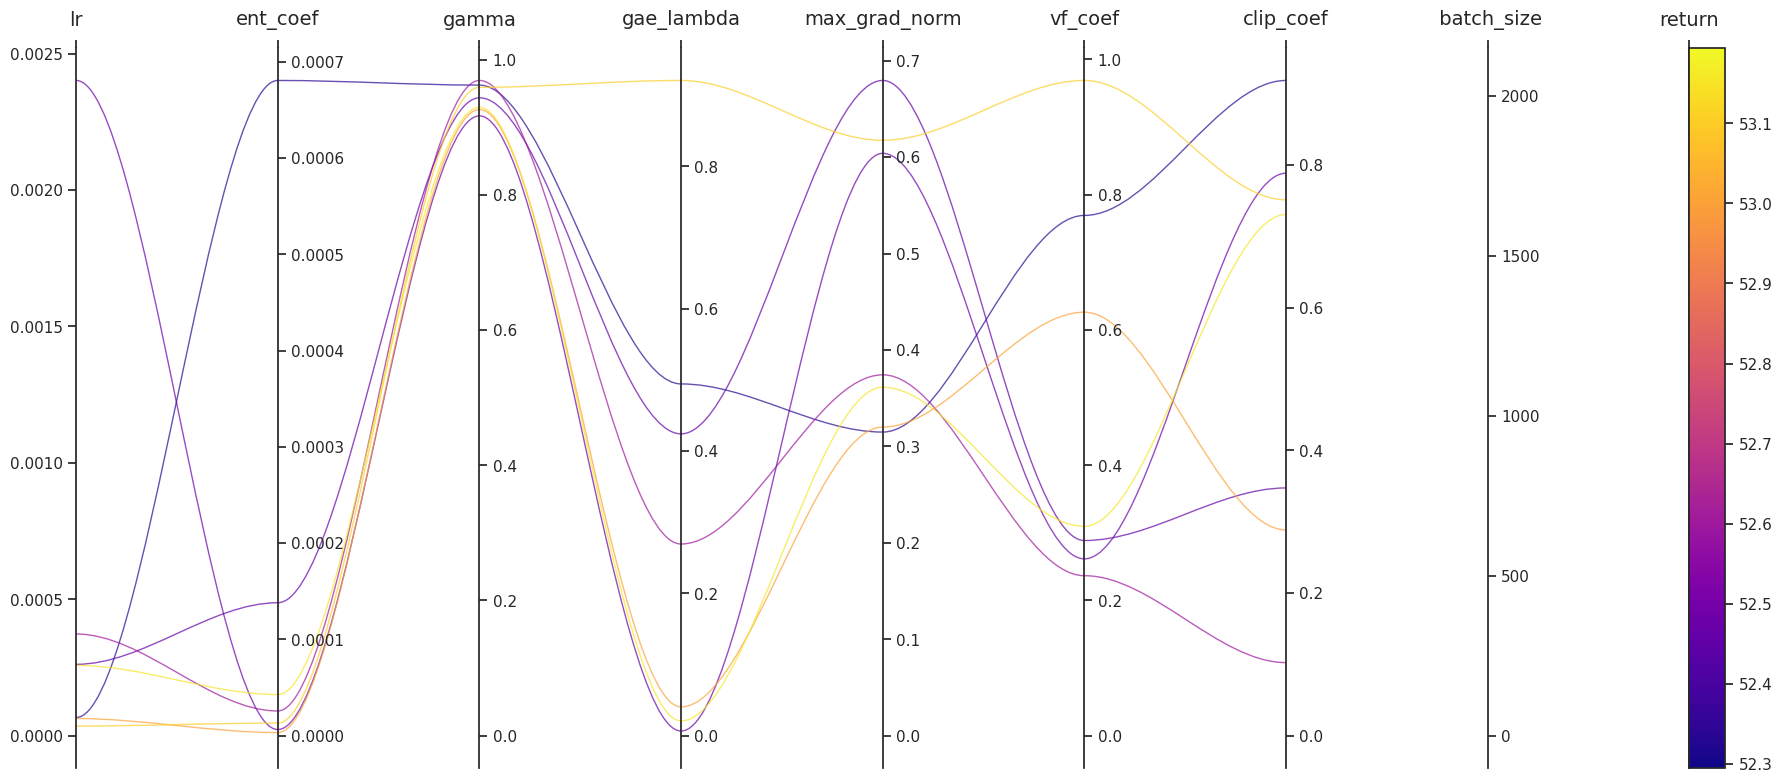

In [6]:
make_parallel_plot(df_hyperparameters).savefig("test.png", dpi=300)#.savefig("parallel_coordinates_IL.png", dpi=200)

Text(0.5, 0, 'Correlation Coefficient')

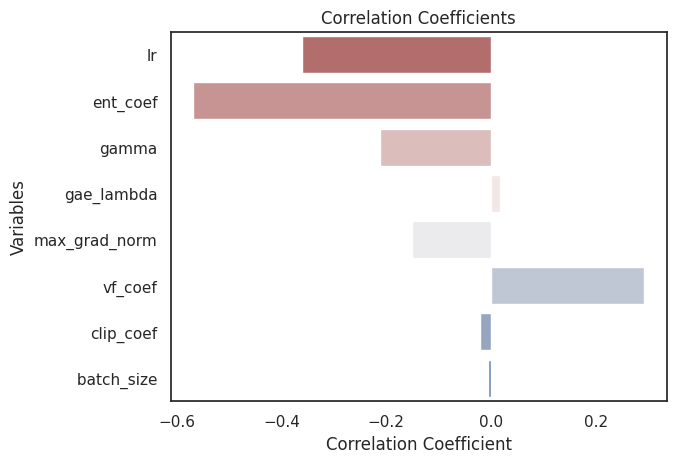

In [7]:
correlations = df_hyperparameters.corr(numeric_only=True)["return"].drop(["return"]).to_frame().transpose()
sns.barplot(
    data=correlations,
    orient="h",
    palette="vlag_r",
)

plt.title('Correlation Coefficients')
plt.ylabel('Variables')
plt.xlabel('Correlation Coefficient')

In [8]:
correlations

,lr,ent_coef,gamma,gae_lambda,max_grad_norm,vf_coef,clip_coef,batch_size
return,-0.36013,-0.568968,-0.212198,0.017498,-0.150882,0.291936,-0.020291,-0.005302


### Validation Metrics

In [9]:
best_n_columns = df.head().index
best_n_columns

Index(['RL__6c24ded8-568b-4800-b8e9-2dcfb22287d4',
       'RL__82b4fab2-9489-4132-a06d-d97260e41ee9',
       'RL__cb3d69ad-b821-4217-a866-6572c4fed1ad',
       'RL__755aab38-4c9b-4754-9a93-0649e03ca5ac',
       'RL__572f2448-4110-4f11-95e2-b37fc8073812'],
      dtype='object', name='Name')

In [10]:
histories = {run.name: run.history(samples=1e9) for run in runs if run.name in best_n_columns}
# histories = {run.name: run.history().set_index("global_step") for run in runs}
len(histories)

5

In [11]:
def get_xy_from(df, key):
    steps = df["_step"]
    values = df[key]
    
    mask = ~np.isnan(values)
    
    return steps[mask], values[mask]

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

def plot_metrics(metrics, labels, windows_size=1):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True, tight_layout=True)
    axs = axs.flatten()

    for ax, (label, data) in zip(axs, metrics.items()):
        # Plot each run
        for algo, (x, y) in data.items():
            
            if windows_size > 1:
                y = moving_average(y, windows_size)
            
            ax.plot(x, y, alpha=0.7, linewidth=1, label=algo)

        # Compute and plot average and std
        # a = np.array([y for x, y in data.values()])
        # for x, y in data.values():
        #     ic(y.shape)
        # ic(a)
        # mean = np.mean(a, axis=0)
        # std = data.std(axis=0)

        # ax.plot(global_steps, mean, color='black', label='Mean', linewidth=2)
        # ax.fill_between(global_steps, mean - std, mean + std,
        #                 color='gray', alpha=0.2, label='±1 STD')

        ax.set_title(labels[label])
        ax.grid(True)

    # Add x-label to bottom plots only
    for ax in axs[3:]:
        ax.set_xlabel("Global Step")
        
    return fig

    # Add y-labels if desired
    # for ax in axs[::3]:  # First column
    #     ax.set_ylabel("Value")

    # Optional: Add legends to one or more plots
    # axs[0].legend()

    # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.show()

### loss

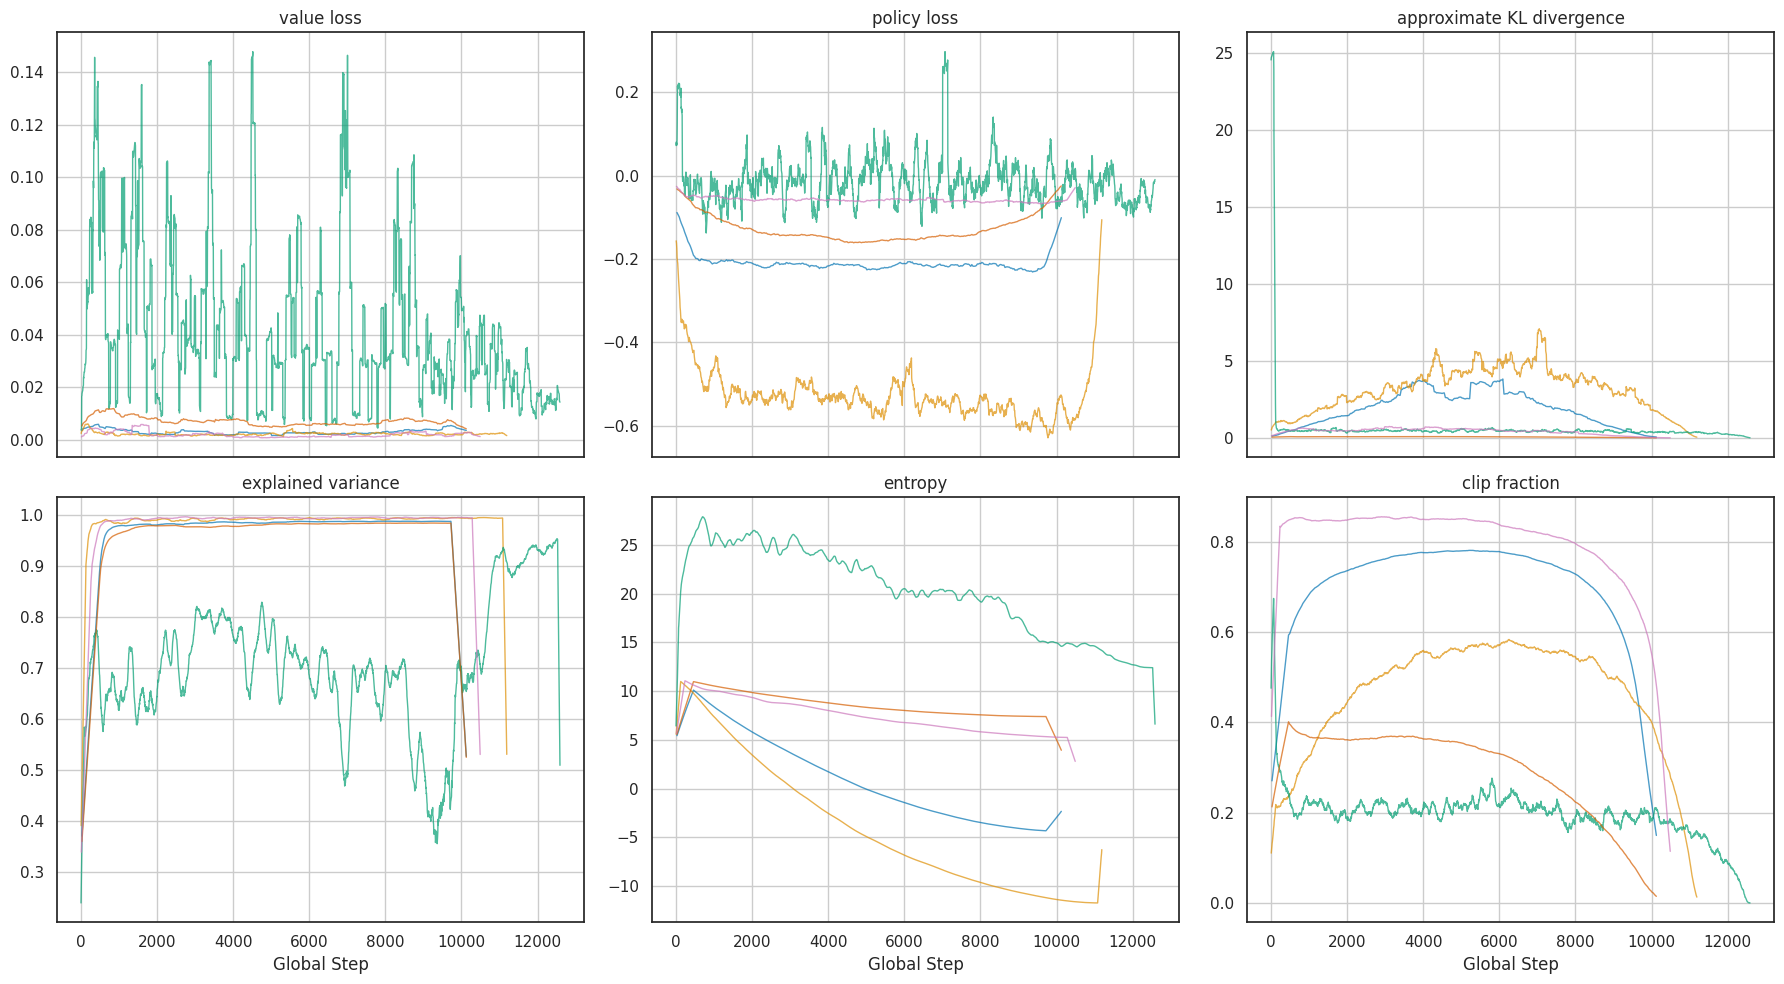

In [13]:
labels = {
    "losses/value_loss" : "value loss", 
    "losses/policy_loss" : "policy loss",
    "losses/approx_kl" : "approximate KL divergence",
    "losses/explained_variance" : "explained variance", 
    "losses/entropy" : "entropy", 
    "losses/clipfrac": "clip fraction",
}

metrics = {
    l: {k: get_xy_from(h, l) for k, h in histories.items()} for l in labels.keys()
}

_ = plot_metrics(metrics, labels, windows_size=30)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Define a range of alpha and beta parameters
alpha_vals = np.linspace(0.5, 5, 100)
beta_vals = np.linspace(0.5, 5, 100)

# Create a meshgrid of alpha and beta values
A, B = np.meshgrid(alpha_vals, beta_vals)

# Compute the entropy for each (alpha, beta) pair
# The result is in nats
entropy_vals = beta.entropy(A, B)

# # Plot the entropy as a contour plot
# plt.figure(figsize=(10, 6))
# contour = plt.contourf(A, B, entropy_vals, levels=50, cmap='viridis')
# plt.colorbar(contour, label='Entropy (nats)')
# plt.xlabel('Alpha (α)')
# plt.ylabel('Beta (β)')
# plt.title('Entropy of Beta Distribution as a Function of α and β')
# plt.tight_layout()
# plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Range of standard deviation values
std_devs = np.linspace(0.01, 5, 500)
variances = std_devs**2

# Differential entropy formula for Gaussian distribution:
# H(X) = 0.5 * log(2 * pi * e * σ^2)
entropy_nats = 0.5 * np.log(2 * np.pi * np.e * variances)

# # Plot entropy vs standard deviation
# plt.figure(figsize=(10, 6))
# plt.plot(std_devs, entropy_nats, label='Entropy (nats)', color='royalblue')
# plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
# plt.xlabel('Standard Deviation (σ)')
# plt.ylabel('Differential Entropy (nats)')
# plt.title('Differential Entropy of Normal Distribution vs Standard Deviation')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


/home/y/git/acn-experiments/.venv/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/y/git/acn-experiments/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


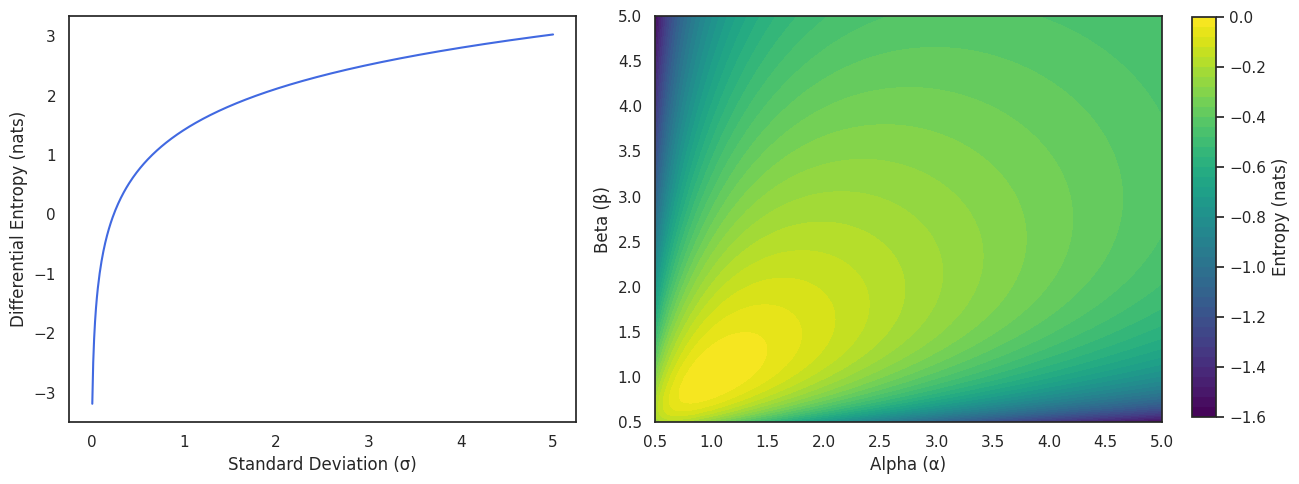

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

axs[0].plot(std_devs, entropy_nats, label='Entropy (nats)', color='royalblue')
axs[0].set_xlabel('Standard Deviation (σ)')
axs[0].set_ylabel('Differential Entropy (nats)')

contour = axs[1].contourf(A, B, entropy_vals, levels=50, cmap='viridis')
axs[1].set_xlabel('Alpha (α)')
axs[1].set_ylabel('Beta (β)')
# plt.colorbar(contour, label='Entropy (nats)')

# fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.8])
fig.colorbar(contour, label='Entropy (nats)', cax=cbar_ax)
pass

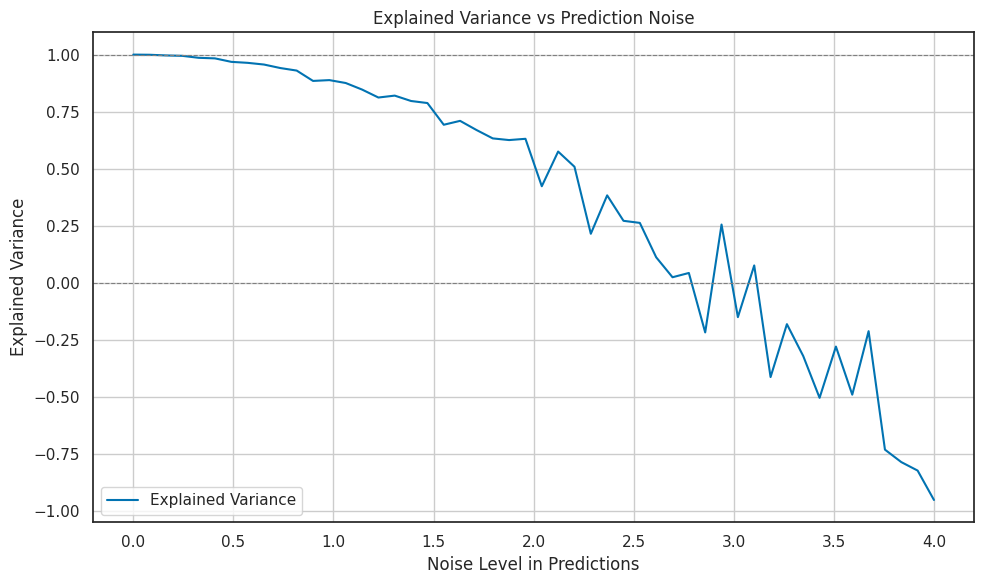

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate true values (e.g., a linear function)
n = 100
y_true = np.linspace(0, 10, n)

# Simulate different levels of prediction noise
noise_levels = np.linspace(0, 4, 50)
explained_variances = []
total_vars = []
total_vars_pred = []
residual_vars = []

for noise_scale in noise_levels:
    # Add noise to simulate predictions
    y_pred = y_true + np.random.normal(0, noise_scale, size=n)
    
    # Calculate total and residual variance
    residual_var = np.var(y_true - y_pred)
    total_var = np.var(y_true)
    total_var_pred = np.var(y_pred)
    residual_vars.append(residual_var)
    
    total_vars.append(total_var)
    total_vars_pred.append(total_var_pred)
    
    # Compute explained variance
    explained_var = 1 - residual_var / total_var
    explained_variances.append(explained_var)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(noise_levels, explained_variances, label='Explained Variance')
# ax.plot(noise_levels, total_vars, label='Variance')
# ax.plot(noise_levels, total_vars_pred, label='Variance pred')
# ax.plot(noise_levels, residual_vars, label='Residual Vars')

ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axhline(1, color='gray', linestyle='--', linewidth=0.8)
ax.set_xlabel('Noise Level in Predictions')
ax.set_ylabel('Explained Variance')
ax.set_title('Explained Variance vs Prediction Noise')
ax.grid(True)
ax.legend()

fig.tight_layout()
plt.show()

### Eval

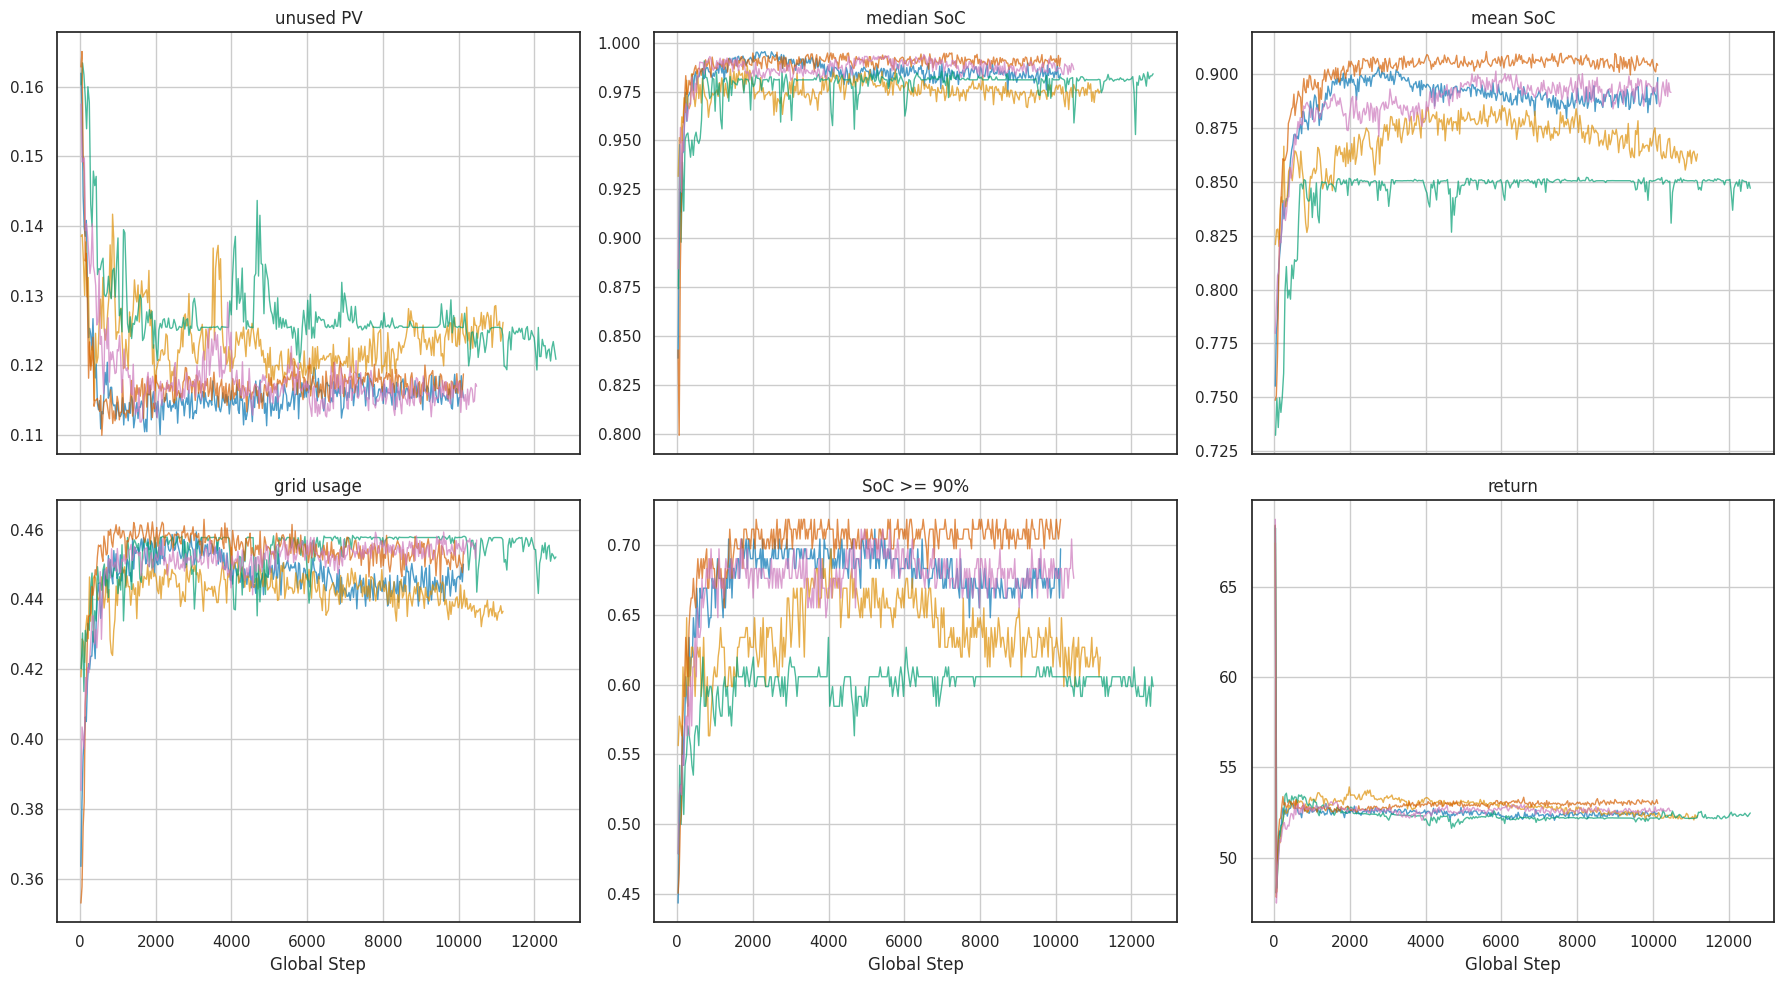

In [19]:
labels = {
    "eval/unused PV" : "unused PV", 
    "eval/median SoC" : "median SoC",
    "eval/mean SoC" : "mean SoC",
    "eval/grid usage" : "grid usage", 
    "eval/SoC >= 90%" : "SoC >= 90%", 
    "eval/return": "return",
}

metrics = {
    l: {k: get_xy_from(h, l) for k, h in histories.items()} for l in labels.keys()
}

_ = plot_metrics(metrics, labels, windows_size=1) 

### train

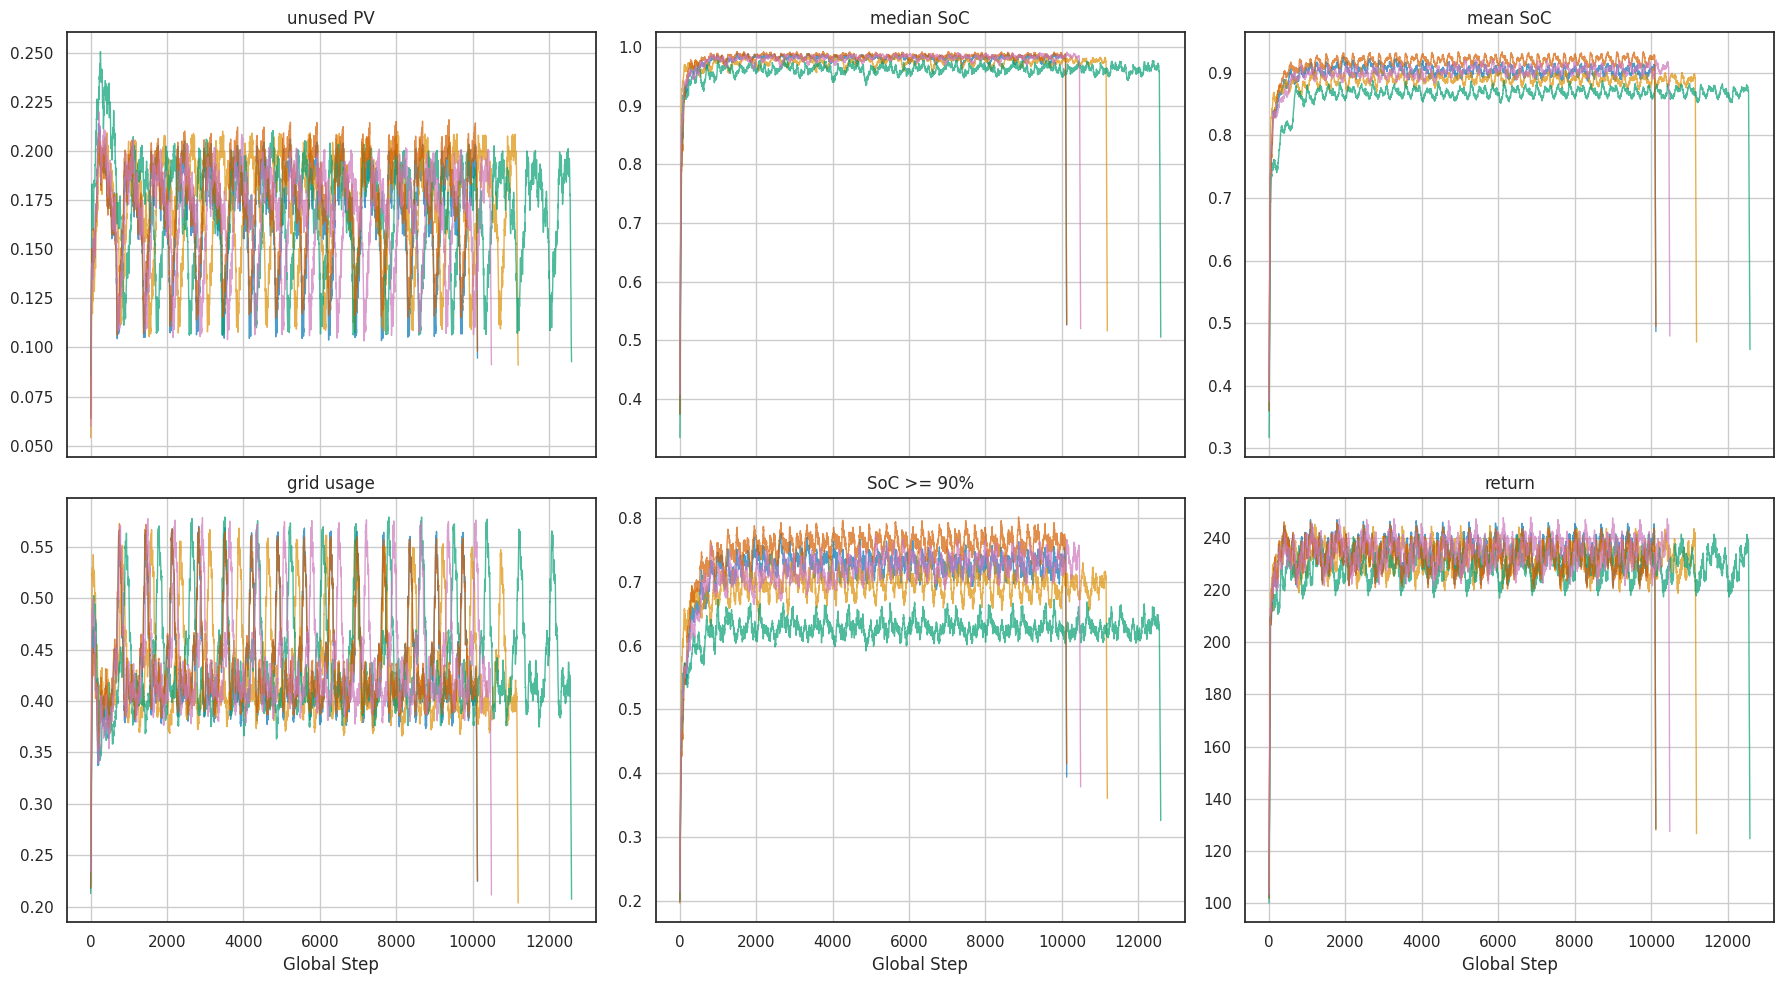

In [20]:
labels = {
    "train/unused PV" : "unused PV", 
    "train/median SoC" : "median SoC",
    "train/mean SoC" : "mean SoC",
    "train/grid usage" : "grid usage", 
    "train/SoC >= 90%" : "SoC >= 90%", 
    "charts/episodic_return": "return",
}

metrics = {
    l: {k: get_xy_from(h, l) for k, h in histories.items()} for l in labels.keys()
}

_ = plot_metrics(metrics, labels, windows_size=30)